In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25)
matplotlib.rc('axes',labelsize=25) 
from astropy.table import Table
import os
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data():
    '''Reads in the Yu et al. 2018 data'''
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

In [3]:
from scipy.optimize import curve_fit
def f(x, A, B):
    return A*x + B

def get_slopes(mlsn, cnc, crc):
    for ml in mls:
        print(ml)
        knc = read_paramdict(ml+'_'+cnc, sort='astero')
        krc = read_paramdict(ml+'_'+crc, sort='astero')
        popt, pcov = curve_fit(f, knc[ml+'_'+cnc].astype(float).values, knc.mu.values, sigma=knc.mu_std.values)
        print('mu(no Correction) = '+str(np.round(popt[0],5))+'x + '+str(np.round(popt[1],5)))

        popt, pcov = curve_fit(f, krc[ml+'_'+crc].astype(float).values, krc.mu.values, sigma=krc.mu_std.values)
        print('mu(RC) = '+str(np.round(popt[0],5))+'x + '+str(np.round(popt[1],5)))
        print('\n')
        
        print('mu(RC)(0.0) = '+str(np.round(krc.mu[krc[ml+'_'+crc]=='0.0'].values[0],5)) + ' pm '+str(np.round(krc.mu_std[krc[ml+'_'+crc]=='0.0'].values[0],5)))
        print('\n')
        
        print('sigma(RC)(0.0) = '+str(np.round(krc.sigma[krc[ml+'_'+crc]=='0.0'].values[0],5)) + ' pm '+str(np.round(krc.sigma_std[krc[ml+'_'+crc]=='0.0'].values[0],5)))
        print('\n')
        
        print('mu(NoCorr)(0.0) = '+str(np.round(knc.mu[knc[ml+'_'+cnc]=='0.0'].values[0],5)) + ' pm '+str(np.round(knc.mu_std[knc[ml+'_'+cnc]=='0.0'].values[0],5)))
        print('\n')
        
        print('sigma(NoCorr)(0.0) = '+str(np.round(knc.sigma[knc[ml+'_'+cnc]=='0.0'].values[0],5)) + ' pm '+str(np.round(knc.sigma_std[knc[ml+'_'+cnc]=='0.0'].values[0],5)))
        print('\n')

In [4]:
def read_paramdict(majorlabel, minorlabel='', sort='astero'):
    '''Reads in results for either:
        -A full run series (majorlabel) where the minorlabel is included as a
            column in the output.
        -A single run (majorlabel and minorlabel).

        Returns a pandas dataframe.
    '''
    loc = __outdir__+majorlabel+'/'

    if minorlabel != '':
        globlist = glob.glob(loc+sort+'_'+str(float(minorlabel))+'_*pars*.csv')
    else:
        globlist = glob.glob(loc+sort+'*_*pars*.csv')

    minorlabels = [os.path.basename(globloc).split('_')[1] for globloc in globlist]
    if sort == 'gaia':
        ccdlabels = [os.path.basename(globloc).split('_')[-2] for globloc in globlist]
        
    df = pd.DataFrame()
    for n, globloc in enumerate(globlist):
        sdf = pd.read_csv(globloc, index_col = 0)
        if minorlabels[n] != 'pars.csv':
            sdf[majorlabel] = minorlabels[n]
            if sort == 'gaia':
                sdf['ccdlabel'] = ccdlabels[n]
        df = df.append(sdf)

    return df.sort_values(by=majorlabel)

In [5]:
def violinplot(mls, kind, bands, cnc, crc, save=''):
    music1 = read_music(mls[0], kind, bands[0], cnc, crc)
    music2 = read_music(mls[1], kind, bands[1], cnc, crc)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    sns.violinplot(music1.tempscales.astype(int).values, music1.chains.values, hue=music1.ncrc.values,
                        palette='Set2',split=True, inner='quartile', ax = ax1)

    sns.violinplot(music2.tempscales.astype(int).values, music2.chains.values, hue=music2.ncrc.values,
                    palette='Set2',split=True, inner='quartile', ax = ax2)
    ax1.grid()
    ax1.set_axisbelow(True)
    ax2.grid()
    ax2.set_axisbelow(True)  
    ax1.set(xlabel=r'Perturbation to Temperature $\Delta T_{\rm eff}$ (K)', ylabel='Position of RC in given band (mag)')
    ax1.set_title(r'$K$ band',fontsize=25)
    ax2.set(xlabel=r'Perturbation to Temperature $\Delta T_{\rm eff}$ (K)')#, ylabel=r'Position of RC in $\emph{Gaia}$ G band (mag)')
    ax2.set_title(r'$G$ band',fontsize=25)    
    plt.setp(ax1.get_legend().get_texts(), fontsize='25')
    plt.setp(ax2.get_legend().get_texts(), fontsize='25')
    fig.tight_layout()
    
    if save is not '':
        plt.savefig(save)
    plt.show()

def read_music(ml, kind, band, cnc, crc):
    chains = np.array([])
    tempscales = np.array([])
    ncrc = np.array([])

    for ts in np.arange(-50.,60.,10.):
        temp = str(ts)
        #Add NC chains & labels
        chain = np.genfromtxt(glob.glob(__outdir__+ml+'_'+cnc+'/'+kind+'_'+temp+'_chains.txt')[0])[0]
        chains = np.append(chains, chain)
        tempscales = np.append(tempscales, np.ones(len(chain))*ts)
        ncrc = np.append(ncrc, ['No Correction']*len(chain))

        #Add RC chains & labels
        chain = np.genfromtxt(glob.glob(__outdir__+ml+'_'+crc+'/'+kind+'_'+temp+'_chains.txt')[0])[0]
        chains = np.append(chains, chain)
        tempscales = np.append(tempscales, np.ones(len(chain))*ts)
        ncrc = np.append(ncrc, ['Clump Corrected']*len(chain))

    music = pd.DataFrame()
    music['chains'] = chains
    music['tempscales'] = tempscales
    music['ncrc'] = ncrc
    return music

## Plot violinplots and uncover gradients

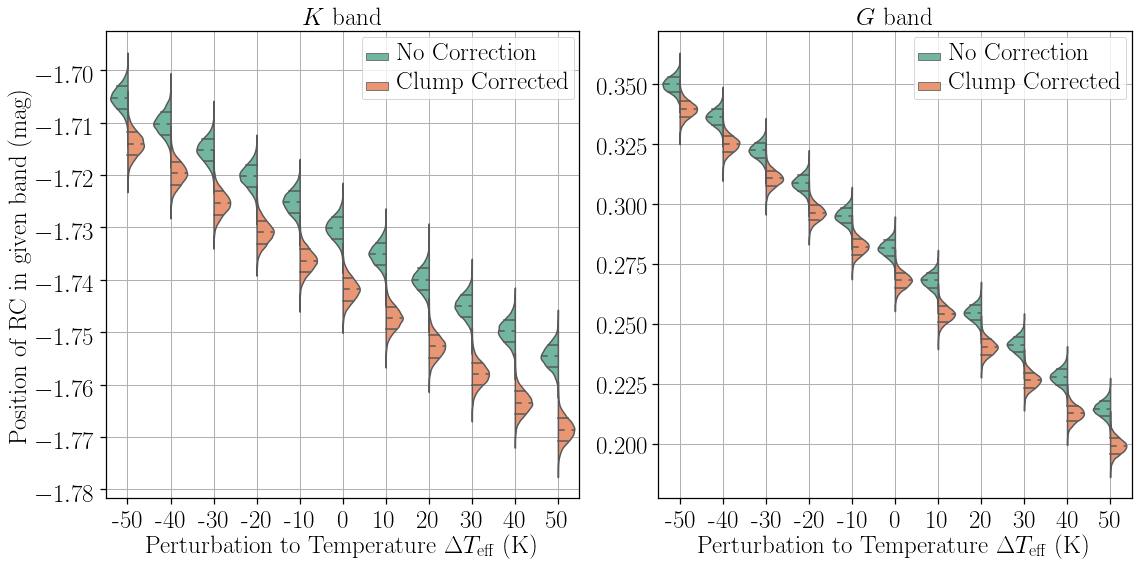

In [10]:
mls = ['K_tempscale', 'GAIA_tempscale']
kind = 'astero'
bands = ['K', 'GAIA']
cnc = 'noCorrection'
crc = 'Clump'
violinplot(mls, kind, bands, cnc, crc, 
    save='/home/oliver/Dropbox/Papers/Hall+18/Figures/yu_posteriors.pdf')
# get_slopes(mls, cnc, crc)

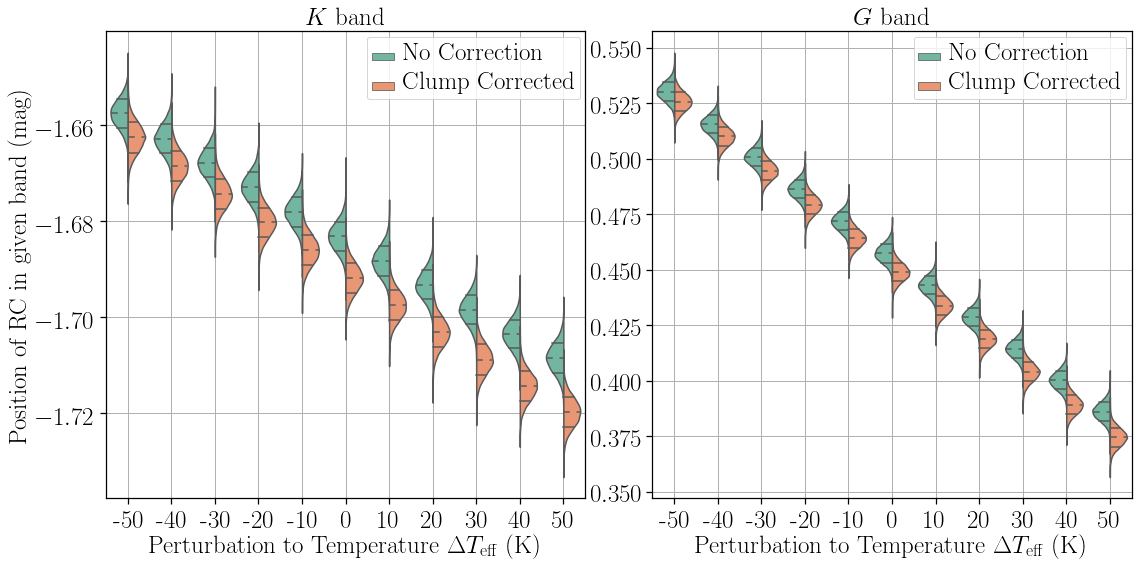

APOKASC_K_tempscale
mu(no Correction) = -0.00051x + -1.68321
mu(RC) = -0.00057x + -1.69167


mu(RC)(0.0) = -1.69195 pm 0.0031


sigma(RC)(0.0) = 0.0356 pm 0.00562


mu(NoCorr)(0.0) = -1.68328 pm 0.00301


sigma(NoCorr)(0.0) = 0.03164 pm 0.00463


APOKASC_GAIA_tempscale
mu(no Correction) = -0.00144x + 0.45773
mu(RC) = -0.00151x + 0.44942


mu(RC)(0.0) = 0.44899 pm 0.00426


sigma(RC)(0.0) = 0.12704 pm 0.0053


mu(NoCorr)(0.0) = 0.4574 pm 0.00415


sigma(NoCorr)(0.0) = 0.11643 pm 0.00579




In [11]:
mls = ['APOKASC_K_tempscale', 'APOKASC_GAIA_tempscale']
kind = 'astero'
bands = ['K', 'GAIA']
cnc = 'noCorrection'
crc = 'Clump'
violinplot(mls, kind, bands, cnc, crc, 
    save='/home/oliver/Dropbox/Papers/Hall+18/Figures/apokasc2_posteriors.pdf')
get_slopes(mls, cnc, crc)

In [8]:
loc = 'Organiser/Pre-final/Gaia_K_tempscale_Clump'
gr = read_paramdict(loc,'0.','gaia')
df = read_data()
df['oo_zp'] = np.ones(len(df))
df['L'] = np.ones(len(df))
for ccd in gr.ccdlabel.astype(int).values:
    df['oo_zp'][df.ccd == ccd] *= gr[gr.ccdlabel == str(ccd)].oo_zp.values[0]
    df['L'][df.ccd == ccd] *= gr[gr.ccdlabel == str(ccd)].L.values[0]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


NameError: name 'cb' is not defined

/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


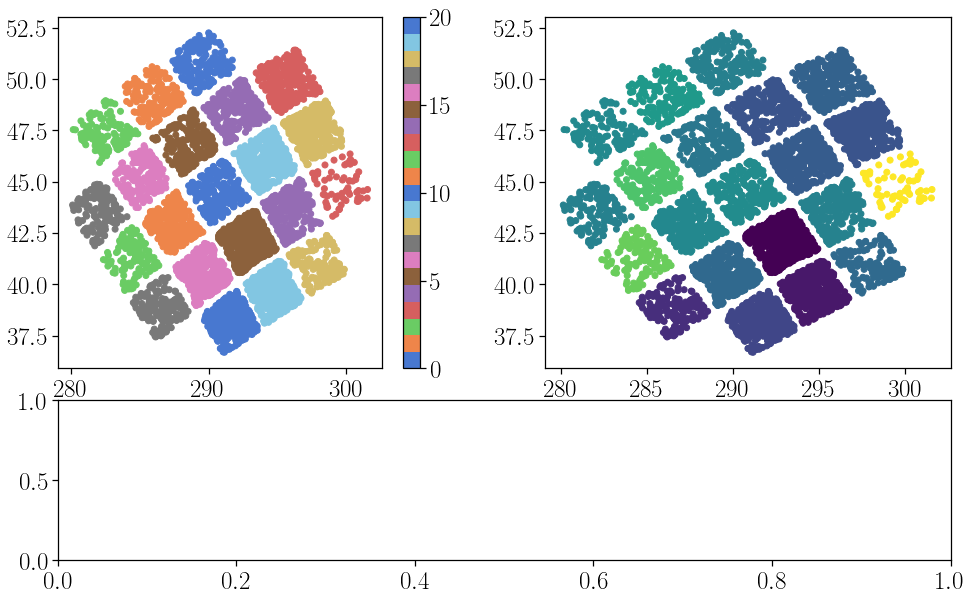

In [9]:
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.color_palette("muted", 21).as_hex())

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6),sharex=True, sharey=True
fig = plt.figure(figsize=(16,10))
grid = plt.GridSpec(3, 2)
ax1= plt.subplot(grid[0:2, 0])
ax2=plt.subplot(grid[0:2, 1])
ax3=plt.subplot(grid[2, :])
                               
c1 = ax1.scatter(df.ra, df.dec, c = df.ccd, cmap=my_cmap)
c2 = ax2.scatter(df.ra, df.dec, c = df.oo_zp, cmap='viridis')

cb1 = fig.colorbar(c1,ax=ax1,ticks=np.arange(0, 22, 5))
cb.ax.invert_yaxis()
cb2 = fig.colorbar(c2, ax=ax2,ticks=np.arange(-32, -10, 4))
cb1.set_label('CCD No.', rotation=270, labelpad=25)
cb2.set_label(r'$\varpi_{\rm zp} (\mu \rm as)$', rotation=270, labelpad=40)
               
ax1.set_xlabel('RA')
ax2.set_xlabel('RA')
ax1.set_ylabel('Dec')
# plt.tight_layout()
# plt.show()

# fig, ax1 = plt.subplots(figsize=(16,4))
(_, caps1,_) = ax3.errorbar(gr.ccdlabel.astype(int).values, gr.oo_zp, yerr=gr.oo_zp_std, fmt='o', capsize=10, label='This Work')
ax3.axhline(-29., c='r', linestyle='-.', alpha=.5,label='Lindegren+18')
# ax1.axhspan(-52.8-2.4-1, -52.8+2.4+1, alpha=.3, color='r',label='Zinn+18')
# ax1.axhspan(-46.-13., -46+13., alpha=.3, color='b',label='Riess+18')
# ax1.axhspan(-35.-16., -35+16., alpha=.3, color='g',label='Sahlholdt \& Silva Aguirre')
(_, caps2,_) = ax3.errorbar(-2.5, -52.8, yerr= 3.4,fmt='o',capsize=10, label='Zinn+18')
(_, caps3,_) = ax3.errorbar(-2., -46., yerr = 13.,fmt='o', capsize=10,label='Riess+18')
(_, caps4,_) = ax3.errorbar(-1.5, -35., yerr = 16.,fmt='o', capsize=10,label='Sahlholdt & Silva Aguirre')
ax3.axvline(-.75, c='k')

# ax1.legend(fontsize=20)
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=6, mode="expand", borderaxespad=0., fontsize=20)
# for cap in [caps1, caps2, caps3, caps4]:
#     print(cap)
#     cap.set_markeredgewidth(1)
ax3.set_ylabel(r'$\varpi_{\rm zp} (\mu \rm as)$')
ax3.grid(alpha=.5)
ax3.set_xticks(np.arange(0., 21))
ax3.set_xlabel('CCD No.')
plt.tight_layout()

plt.savefig('/Users/Oliver/Dropbox/Papers/Hall+18/Figures/ccd_full.pdf')
plt.show()

In [ ]:
loc = 'Organiser/Pre-final/Gaia_K_tempscale_Clump'
gr = read_paramdict(loc,'0.','gaia')
gr['ccdlabel'] = gr.ccdlabel.astype(int)
gr.sort_values(by='ccdlabel',inplace=True)
size=[]
for ccd in gr.ccdlabel.values:
    size.append(len(df[df.ccd == ccd]))
plt.errorbar(gr.oo_zp.values, size, xerr=gr.oo_zp_std, fmt='o')
plt.xlabel('oozp')
plt.ylabel('size')

In [ ]:
gr.sort_values(by='ccdlabel')